# understanding AA pair reactivity trends

# Summary

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, ttest_ind
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)
from dms_3d_features.stats import r2, check_pairwise_statistical_significance

## extra functions

In [3]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [4]:
def plot_residue_trends(df, color="tab:gray", col="ln_r_data"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df[col].max() - df[col].min()
    extra_space = 0.4 * data_range
    xlim_min = df[col].min() - extra_space
    xlim_max = df[col].max()

    plot_violins_w_percent(
        df,
        col,
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        col,
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        col,
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [5]:
def plot_flanking_pairs_distribution(df):
    # Combine the flanking pairs into a single column
    df["flanking_pairs"] = df["m_second_flank_bp_5p"] + "-" + df["m_second_flank_bp_3p"]
    # Calculate mean r_data_ratio for each flanking pair
    mean_r_data_ratio = (
        df.groupby("flanking_pairs")["r_data_ratio"].mean().sort_values(ascending=False)
    )
    # Create the rotated violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(
        x="r_data_ratio",
        y="flanking_pairs",
        data=df,
        order=mean_r_data_ratio.index[::-1],
        cut=0,
        orient="h",
        density_norm="width",
    )
    # Customize the plot
    plt.title("Distribution of r_data_ratio for Different Flanking Pairs")
    plt.xlabel("r_data_ratio")
    plt.ylabel("Flanking Pairs (5' - 3')")
    # Add count labels
    counts = df["flanking_pairs"].value_counts()
    for i, flanking_pair in enumerate(mean_r_data_ratio.index[::-1]):
        count = counts[flanking_pair]
        plt.text(plt.xlim()[1] + 0.5, i, f"n={count}", ha="left", va="center")

### summary tables

In [6]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [7]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

### misc

In [8]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [9]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

## load data

In [11]:
DATA_PATH = "../data"

In [12]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A' and no_of_interactions == 1"
).copy()

In [13]:
dataframe_column_table(df_pdb)

                         0                    1                   2                  3
                m_sequence                r_nuc           pdb_r_pos             r_type
             pdb_r_bp_type           pdb_r_pair no_of_conformations no_of_interactions
no_of_partner_interactions             pdb_name            pdb_path            pdb_res
               both_purine      both_pyrimidine          constructs        likely_pair
             m_flank_bp_5p        m_flank_bp_3p       m_orientation              m_pos
      m_second_flank_bp_5p m_second_flank_bp_3p         m_structure            m_token
                    n_pdbs            pair_type              p5_res            p5_type
                    p3_res              p3_type              r_data          r_loc_pos
                     r_pos              r_stack           ln_r_data            z_score
            r_data_outlier                  NaN                 NaN                NaN


# All residues

## percent under -5.45

In [14]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
print(len(df_aa["m_sequence"].unique()))

169


In [15]:
df_cc = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 6.63%       |   26446 |


In [16]:
df_aa = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '1x1'"
).copy()
generate_threshold_summary(df_aa, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 4.62%       |     866 |


## Stacking trends

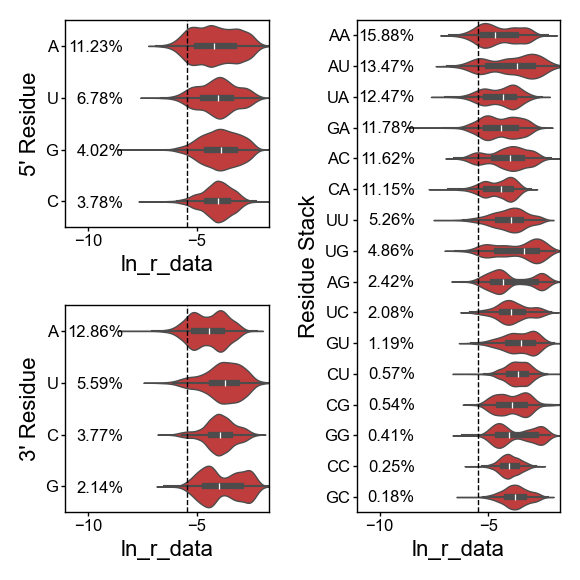

In [17]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
plot_residue_trends(df_aa, color="tab:red")

In [18]:
# Example usage:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "r_stack", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
56,CA,CU,4.477255e-285
58,CA,GC,2.712519e-247
60,CA,GU,2.263035e-230
6,AA,CU,2.134566e-220
88,CU,UA,1.319331e-215
...,...,...,...
3,AA,CA,5.696991e-01
95,GA,UA,5.827174e-01
51,AU,UC,6.398255e-01
90,CU,UG,8.678416e-01


In [19]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "p5_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
1,A,G,7.169208e-46
3,C,G,8.937500e-30
5,G,U,3.919105e-17
2,A,U,3.605718e-10
0,A,C,8.208881e-07
4,C,U,3.972950e-02


In [20]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "p3_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
0,A,C,0.000000e+00
1,A,G,0.000000e+00
2,A,U,0.000000e+00
4,C,U,2.521329e-22
3,C,G,7.419531e-16
5,G,U,2.782849e-01


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


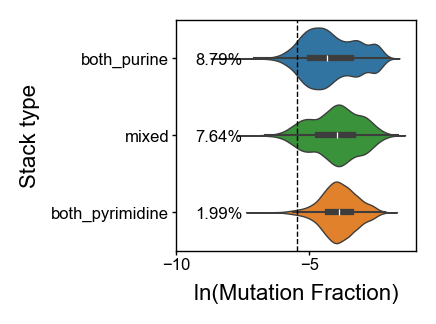

In [21]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
df_aa["stack_type"] = df_aa.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_aa,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [22]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
create_summary_table(df_aa, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AA        | 15.88%          |    2110 |
| AU        | 13.47%          |    1655 |
| UA        | 12.47%          |    2238 |
| GA        | 11.78%          |    1825 |
| AC        | 11.62%          |    1825 |
| CA        | 11.15%          |    2036 |
| UU        | 5.26%           |    1425 |
| UG        | 4.86%           |    1483 |
| AG        | 2.42%           |    1612 |
| UC        | 2.08%           |    1635 |
| GU        | 1.19%           |    1256 |
| CU        | 0.57%           |    1408 |
| CG        | 0.54%           |    1475 |
| GG        | 0.41%           |    1212 |
| CC        | 0.25%           |    1624 |
| GC        | 0.18%           |    1627 |


## Ratio in reactivity

In [57]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
new_rows = []
for i, group in df_aa.groupby(["m_sequence", "constructs", "m_pos"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_data", ascending=True)
        new_row = sorted_group.iloc[1].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[0]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[0]["r_stack"]
        new_rows.append(new_row)
df_aa_combined = pd.DataFrame(new_rows)

In [58]:
df_aa_combined = df_aa_combined.sort_values(by="r_data_ratio", ascending=False)

In [41]:
dataframe_column_table(df_aa_combined)
### what is related to large ratios in reactivity

           0                    1                    2             3
 both_purine      both_pyrimidine           constructs      has_pdbs
 likely_pair        m_flank_bp_5p        m_flank_bp_3p m_orientation
       m_pos m_second_flank_bp_5p m_second_flank_bp_3p    m_sequence
 m_structure              m_token               n_pdbs     pair_type
      p5_res              p5_type               p3_res       p3_type
      r_data                r_nuc            r_loc_pos         r_pos
      r_type              r_stack             pdb_path     pdb_r_pos
   ln_r_data              z_score       r_data_outlier  r_data_ratio
r_data_other                  NaN                  NaN           NaN


### what is related to large ratios in reactivity

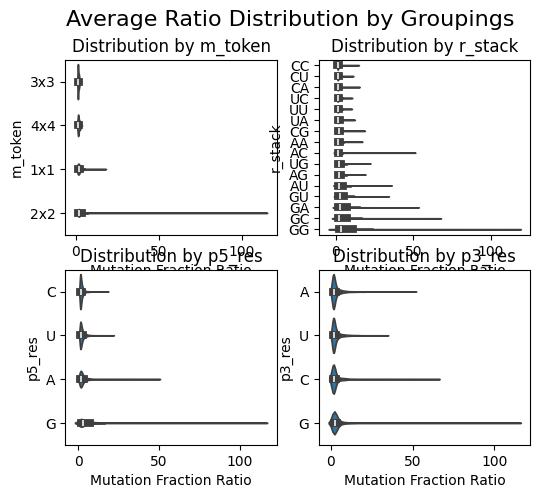

In [59]:
# Calculate average ratio for different groupings
groupings = ["m_token", "r_stack", "p5_res", "p3_res"]

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
fig.suptitle("Average Ratio Distribution by Groupings", fontsize=16)

for idx, group in enumerate(groupings):
    row = idx // 2
    col = idx % 2
    # Calculate mean r_data_ratio for each group and sort by mean
    sorted_data = (
        df_aa_combined.groupby(group)["r_data_ratio"].mean().sort_values().index
    )
    sorted_df = df_aa_combined.set_index(group).loc[sorted_data].reset_index()

    # Create violin plot
    sns.violinplot(
        x="r_data_ratio",
        y=group,
        data=sorted_df,
        ax=axes[row, col],
        orient="h",
    )

    axes[row, col].set_title(f"Distribution by {group}")
    axes[row, col].set_xlabel("Mutation Fraction Ratio")
    axes[row, col].set_ylabel(group)

In [61]:
# Calculate the average, standard deviation, and count of r_data_ratio for each combination of r_stack and r_stack_other
summary_table = (
    df_aa_combined.groupby(["r_stack", "r_stack_other"])
    .agg(
        avg_ratio=("r_data_ratio", "mean"),
        std_ratio=("r_data_ratio", "std"),
        count=("r_data_ratio", "size"),
    )
    .reset_index()
)

# Sort the summary table by highest average ratio
summary_table = summary_table.sort_values(by="avg_ratio", ascending=False)

# Print the summary table using tabulate
print("Summary Table of r_stack and r_stack_other:")
print(
    tabulate(
        summary_table,
        headers=["r_stack", "r_stack_other", "Average Ratio", "Std Ratio", "Count"],
        floatfmt=".2f",
        tablefmt="grid",
    )
)

Summary Table of r_stack and r_stack_other:
+----+-----------+-----------------+-----------------+-------------+---------+
|    | r_stack   | r_stack_other   |   Average Ratio |   Std Ratio |   Count |
+====+===========+=================+=================+=============+=========+
| 59 | GG        | CA              |           17.45 |       13.32 |     395 |
+----+-----------+-----------------+-----------------+-------------+---------+
| 53 | GC        | GA              |           10.33 |        7.72 |     399 |
+----+-----------+-----------------+-----------------+-------------+---------+
| 48 | GA        | UA              |            8.39 |        5.82 |     393 |
+----+-----------+-----------------+-----------------+-------------+---------+
| 63 | GU        | AA              |            7.25 |        4.75 |     370 |
+----+-----------+-----------------+-----------------+-------------+---------+
| 21 | AU        | UU              |            5.05 |        5.28 |     357 |
+----+--

In [62]:
# Filter the dataframe for rows where r_stack == 'GG' and r_stack_other == 'CA'
filtered_df = df_aa_combined[
    (df_aa_combined["r_stack"] == "GG") & (df_aa_combined["r_stack_other"] == "CA")
]

# Get the list of unique m_sequences
unique_m_sequences = filtered_df["m_sequence"].unique()

# Print the list of unique m_sequences
print("List of unique m_sequences with r_stack == 'GG' and r_stack_other == 'CA':")
print(unique_m_sequences)

List of unique m_sequences with r_stack == 'GG' and r_stack_other == 'CA':
['AGAG&CAAU' 'CAAA&UGAG' 'CAAC&GGAG' 'CAAG&CGAG']


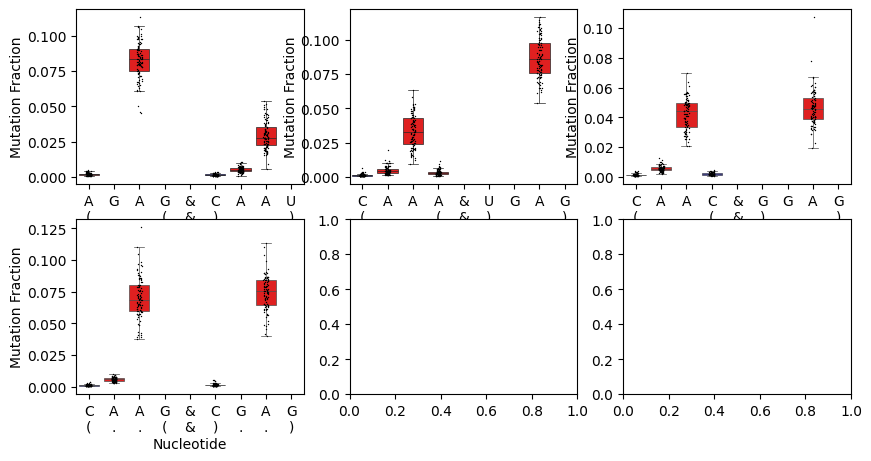

In [69]:
# Determine the number of rows and columns for the subplots
num_sequences = len(unique_m_sequences)
num_cols = 3
num_rows = (num_sequences + num_cols - 1) // num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# For each unique m_sequence, generate a boxplot and stripplot in subplots
for idx, sequence in enumerate(unique_m_sequences):
    # Filter the dataframe for the current m_sequence
    sequence_df = df[df["m_sequence"] == sequence]
    plot_motif_boxplot_stripplot(sequence_df, show_structure=True, ax=axes[idx])

Text(95.72222222222221, 0.5, 'r_stack')

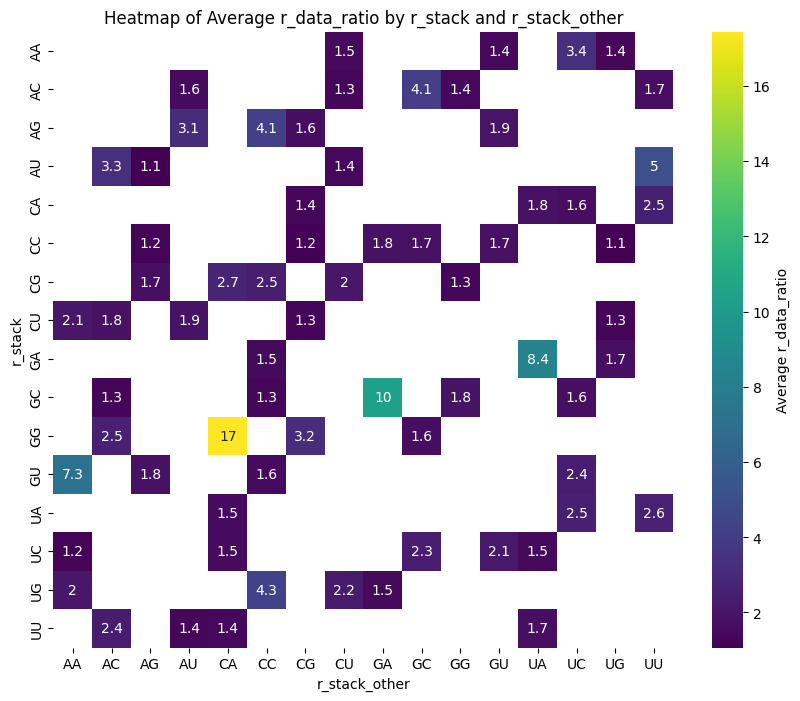

In [49]:
# Create a pivot table for the heatmap
df_sub = df_aa_combined.query("m_token == '2x2'")
heatmap_data = df_sub.pivot_table(
    index="r_stack", columns="r_stack_other", values="r_data_ratio", aggfunc="mean"
)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, cmap="viridis", cbar_kws={"label": "Average r_data_ratio"}
)
plt.title("Heatmap of Average r_data_ratio by r_stack and r_stack_other")
plt.xlabel("r_stack_other")
plt.ylabel("r_stack")

### what motifs have the highest ratios

In [32]:
df_aa_combined = df_aa_combined.sort_values(by="r_data_ratio", ascending=False)
# Calculate the average r_data_ratio for each unique m_sequence

In [33]:
# Calculate the average r_data_ratio for each unique m_sequence
average_ratios = (
    df_aa_combined.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Get the top 10 unique m_sequences with the highest average ratio
top_10_sequences = average_ratios.head(10)

# Create a table-like output
print("Top 10 Unique m_sequences with Highest Average Ratio:")
print("-" * 50)
print(f"{'m_sequence':<15} | {'Average r_data_ratio':>20}")
print("-" * 50)
for sequence, ratio in top_10_sequences.items():
    print(f"{sequence:<15} | {ratio:>20.2f}")
print("-" * 50)

Top 10 Unique m_sequences with Highest Average Ratio:
--------------------------------------------------
m_sequence      | Average r_data_ratio
--------------------------------------------------
CAAA&UGAG       |                26.58
AGAG&CAAU       |                19.88
GAAA&UGAC       |                14.39
CAAG&CGAG       |                13.71
AAAA&UGAU       |                11.53
UAAA&UGAA       |                10.65
CGAC&GAAG       |                10.58
AGAA&UAAU       |                10.02
AGAC&GAAU       |                 9.99
AAUA&UUAU       |                 9.26
--------------------------------------------------


<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

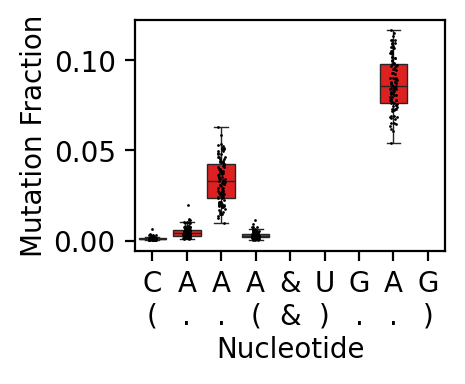

In [35]:
df_sub = df.query('m_sequence == "CAAA&UGAG"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

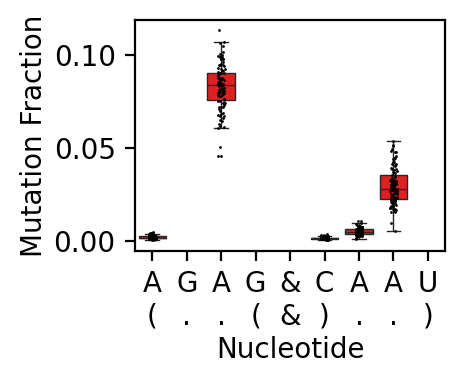

In [36]:
df_sub = df.query('m_sequence == "AGAG&CAAU"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

### which pdbs have the highest ratios

In [37]:
# Find the row with the highest ratio that has a PDB
highest_ratio_with_pdb = (
    df_aa_combined[df_aa_combined["has_pdbs"] == True]
    .sort_values(by="r_data_ratio", ascending=False)
    .iloc[0]
)

print(f"Highest ratio with PDB: {highest_ratio_with_pdb['r_data_ratio']:.2f}")
print(f"PDB path: {highest_ratio_with_pdb['pdb_path']}")

Highest ratio with PDB: 20.05
PDB path: ['data/pdbs_w_2bp/AAAG_CGAU/TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb']


In [38]:
# Example usage:
highest_ratio_with_pdb["pdb_path"] = highest_ratio_with_pdb["pdb_path"][0]
viewer = visualize_molecule(highest_ratio_with_pdb)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### why is there a large spread

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'CAAA&UGAG'),
  Text(1, 0, 'AGAG&CAAU'),
  Text(2, 0, 'CAAG&CGAG'),
  Text(3, 0, 'CAAC&GGAG'),
  Text(4, 0, 'CAGG&CGAG'),
  Text(5, 0, 'CAGA&UGAG'),
  Text(6, 0, 'CAAC&GAGG'),
  Text(7, 0, 'AAAC&GAGU'),
  Text(8, 0, 'AGAG&CAGU'),
  Text(9, 0, 'GAAC&GAGC'),
  Text(10, 0, 'GAGA&UAAC'),
  Text(11, 0, 'GAGC&GGAC'),
  Text(12, 0, 'CGAC&GAGG'),
  Text(13, 0, 'CAC&GAG'),
  Text(14, 0, 'CAGC&GGAG'),
  Text(15, 0, 'AGAC&GAGU'),
  Text(16, 0, 'GAGA&UGAC')])

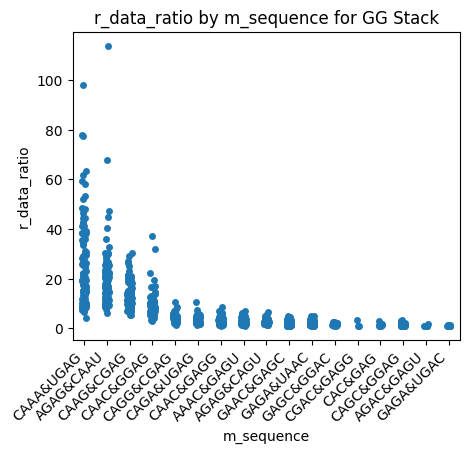

In [43]:
df_gg_stack = df_aa_combined.query("r_stack == 'GG'")
df_gg_stack = df_gg_stack.sort_values(by="r_data_ratio", ascending=False)

# Calculate average r_data_ratio for each unique m_sequence
avg_ratios = (
    df_gg_stack.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Plot average ratios as a stripplot
plt.figure(figsize=(5, 4))
sns.stripplot(
    x="m_sequence", y="r_data_ratio", data=df_gg_stack, order=avg_ratios.index
)
plt.title("r_data_ratio by m_sequence for GG Stack")
plt.xlabel("m_sequence")
plt.ylabel("r_data_ratio")
plt.xticks(rotation=45, ha="right")

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

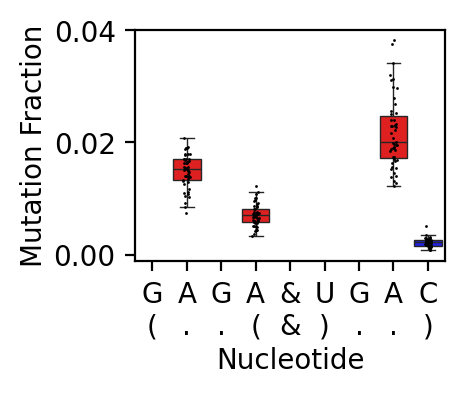

In [44]:
df_sub = df.query('m_sequence == "GAGA&UGAC"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

#### Is there a relationship between the number of aligned residues and the reactivity ratio?
Doesnt appear to be

Text(0.5, 1.0, 'Scatter plot of r_data_ratio vs num_aligned')

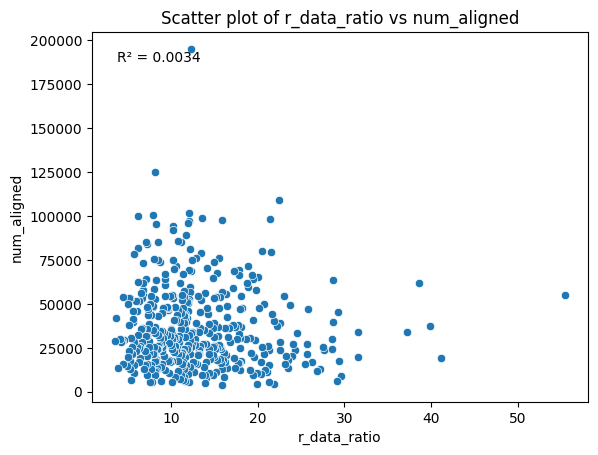

In [32]:
# Function to get num_aligned and sn for a given construct
def get_construct_info(construct_name):
    construct_row = df_constructs[df_constructs["name"] == construct_name].iloc[0]
    return construct_row["num_aligned"], construct_row["sn"]


# Apply the function to each row in df_cc_1x1
df_cu_stack["num_aligned"], df_cu_stack["sn"] = zip(
    *df_cu_stack["constructs"].apply(get_construct_info)
)

# Create the scatter plot
sns.scatterplot(x="r_data_ratio", y="num_aligned", data=df_cu_stack)

# Calculate r2
slope, intercept, r_value, p_value, std_err = linregress(
    df_cu_stack["r_data_ratio"], df_cu_stack["num_aligned"]
)
r2 = r_value**2

# Add r2 value to the plot
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.4f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="left",
)

plt.xlabel("r_data_ratio")
plt.ylabel("num_aligned")
plt.title("Scatter plot of r_data_ratio vs num_aligned")

#### is there anything intersting in the worst ratio

In [33]:
# Create a DataFrame with the last row of df_cu_stack
last_row_df = pd.DataFrame(df_cu_stack.iloc[-1]).T
# Reset the index to make the row index a column
last_row_df = last_row_df.reset_index()
# Melt the DataFrame to create a table with multiple columns
melted_df = pd.melt(
    last_row_df, id_vars=["index"], var_name="row_index", value_name="value"
)
melted_df["row"] = melted_df["row_index"] + " = " + melted_df["value"].astype(str)

num_columns = 4
melted_df["display_column"] = melted_df.index % num_columns
melted_df["display_row"] = melted_df.index // num_columns
melted_df.drop(columns=["index"], inplace=True)

pivot_data = melted_df.pivot(
    index="display_row", columns="display_column", values="row"
)
pivot_data.columns.name = None
pivot_data.index.name = None
pivot_data

,0,1,2,3
0,both_purine = False,both_pyrimidine = True,constructs = construct4787,has_pdbs = False
1,likely_pair = CC,m_flank_bp_5p = AU,m_flank_bp_3p = GC,m_orientation = non-flipped
2,m_pos = 2,m_second_flank_bp_5p = CG,m_second_flank_bp_3p = GC,m_sequence = AUCG&CCUU
3,m_structure = (..(&)..),m_token = 2x2,n_pdbs = 0,pair_type = nan
4,p5_res = C,p5_type = PYRIMIDINE,p3_res = U,p3_type = PYRIMIDINE
5,r_data = 0.007980000000000001,r_nuc = C,r_loc_pos = 6,r_pos = 93
6,r_type = NON-WC,r_stack = CU,pdb_path = [],pdb_r_pos = 12
7,ln_r_data = -4.8308168675,z_score = 3.2111344482,r_data_outlier = True,r_data_ratio = 3.5275689223057642
8,r_data_other = 0.02815,num_aligned = 28959,sn = 7.88,NaN


<Axes: >

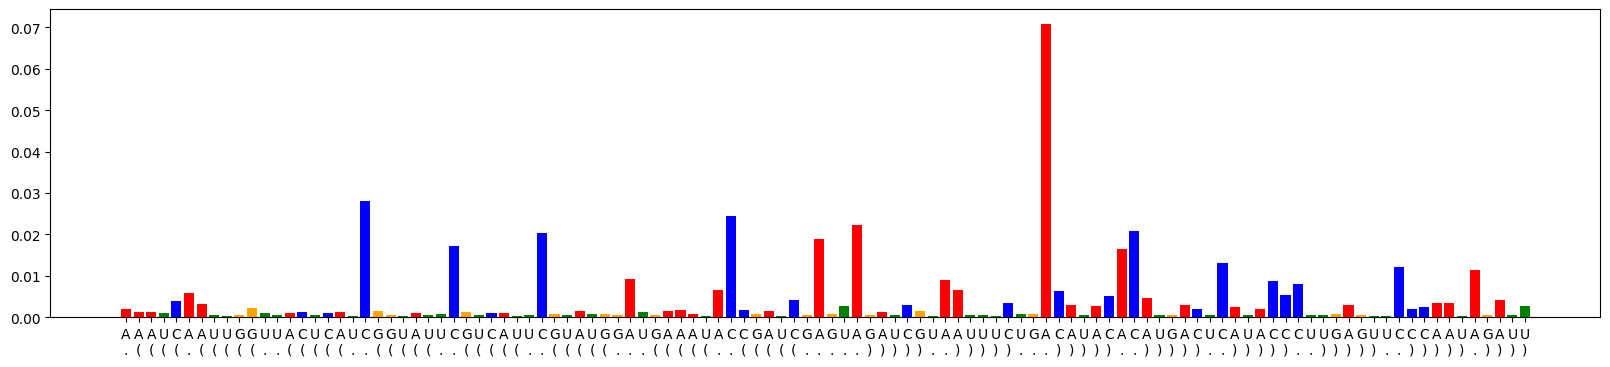

In [34]:
# lowest ratio G
plot_pop_avg_from_row(df_constructs.query("name == 'construct4787'").iloc[0])

### is the large spread in ratio related to second flanking base pairs

In [35]:
# Calculate the mean of r_data_ratio for each m_orientation
mean_r_data_ratio = (
    df_cu_stack.groupby("m_orientation")["r_data_ratio"].mean().reset_index()
)
# Display the results as a table
display(mean_r_data_ratio.style.format({"r_data_ratio": "{:.2f}"}))

,m_orientation,r_data_ratio
0,flipped,12.83
1,non-flipped,13.73


In [36]:
analyze_flanking_pairs(df_cu_stack)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,10.5,12.0,9.9,9.2
CG,13.1,18.2,16.5,14.5
GC,16.8,22.0,17.3,12.9
UA,14.1,16.4,12.3,12.0


m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,42.0,21.0,25.0,49.0
CG,17.0,12.0,14.0,19.0
GC,30.0,16.0,14.0,30.0
UA,40.0,20.0,33.0,42.0


In [37]:
analyze_flanking_pairs(df_cc_combined)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,3.6,3.7,3.5,3.5
CG,3.5,4.2,3.8,3.4
GC,4.7,5.5,4.3,4.0
UA,4.0,3.7,3.8,3.6


m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,553.0,361.0,314.0,589.0
CG,317.0,189.0,218.0,360.0
GC,326.0,184.0,217.0,371.0
UA,565.0,382.0,348.0,644.0


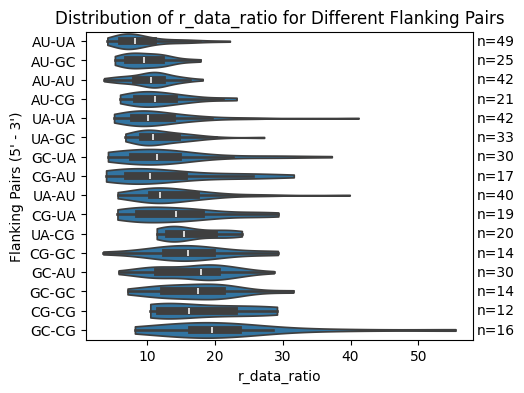

In [38]:
plot_flanking_pairs_distribution(df_cu_stack)

# single mismatches

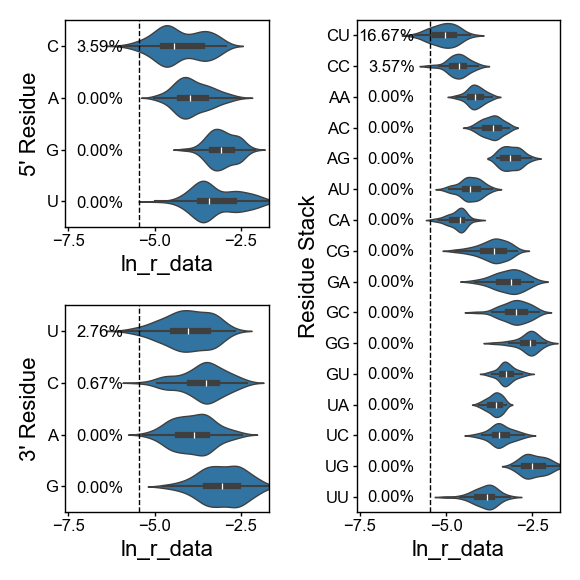

In [39]:
df_cc_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
plot_residue_trends(df_cc_1x1, color="tab:blue")

In [40]:
create_summary_table(df_cc_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 16.67%          |      30 |
| CC        | 3.57%           |      28 |
| AA        | 0.00%           |      41 |
| UU        | 0.00%           |      41 |
| AC        | 0.00%           |      50 |
| GU        | 0.00%           |      50 |
| AG        | 0.00%           |      30 |
| AU        | 0.00%           |      60 |
| CA        | 0.00%           |      30 |
| UG        | 0.00%           |      61 |
| GG        | 0.00%           |      28 |
| CG        | 0.00%           |      79 |
| GA        | 0.00%           |      30 |
| UC        | 0.00%           |      30 |
| GC        | 0.00%           |      42 |
| UA        | 0.00%           |      42 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


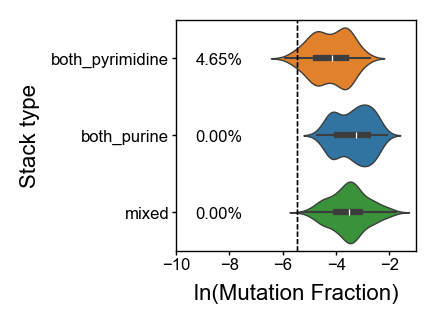

In [41]:
df_cc_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '1x1'"
).copy()
df_cc_1x1["stack_type"] = df_cc_1x1.apply(assign_stack_type, axis=1)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_cc_1x1,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

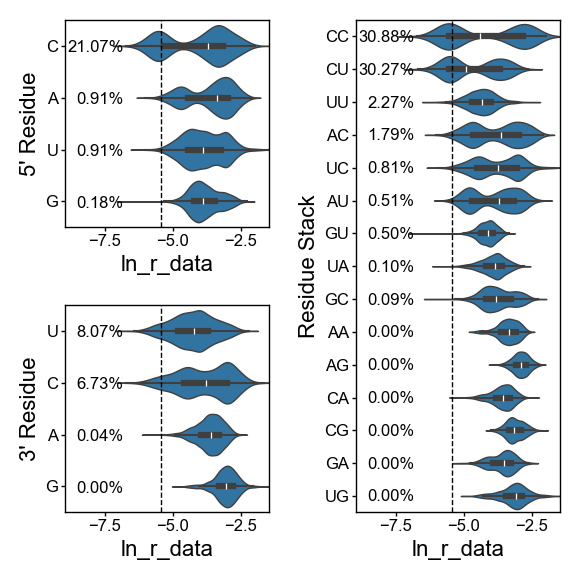

In [42]:
df_cc_2x2 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC' and m_token == '2x2'"
).copy()
plot_residue_trends(df_cc_2x2, color="tab:blue")

In [43]:
create_summary_table(df_cc_2x2, "r_stack")
# with PDB info with known pairs

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 30.88%          |    1143 |
| CU        | 30.27%          |     783 |
| UU        | 2.27%           |    1189 |
| AC        | 1.79%           |    1785 |
| UC        | 0.81%           |    1981 |
| AU        | 0.51%           |     987 |
| GU        | 0.50%           |     401 |
| UA        | 0.10%           |     993 |
| GC        | 0.09%           |    1063 |
| AA        | 0.00%           |     798 |
| GA        | 0.00%           |     202 |
| AG        | 0.00%           |     492 |
| CA        | 0.00%           |     593 |
| CG        | 0.00%           |     281 |
| UG        | 0.00%           |     683 |


# with PDB info with known pairs

## stacking

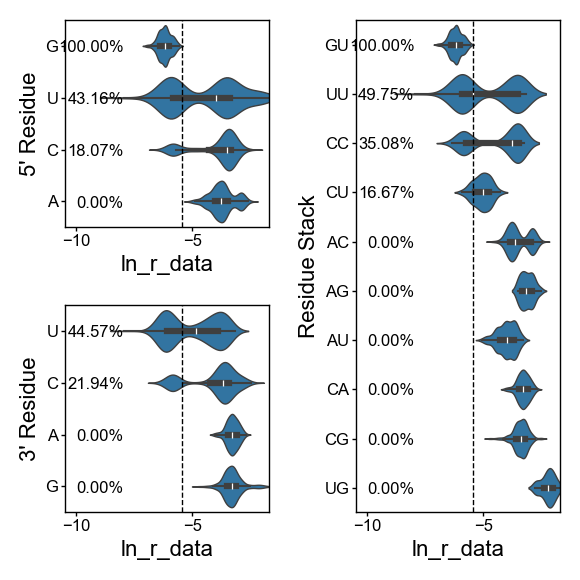

In [44]:
df_pdb_cc = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-C' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_cc, color="tab:blue")

In [45]:
create_summary_table(df_pdb_cc, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| GU        | 100.00%         |     312 |
| UU        | 49.75%          |     203 |
| CC        | 35.08%          |     496 |
| CU        | 16.67%          |      60 |
| AC        | 0.00%           |     297 |
| AU        | 0.00%           |     374 |
| AG        | 0.00%           |      60 |
| CG        | 0.00%           |     359 |
| UG        | 0.00%           |      31 |
| CA        | 0.00%           |     103 |


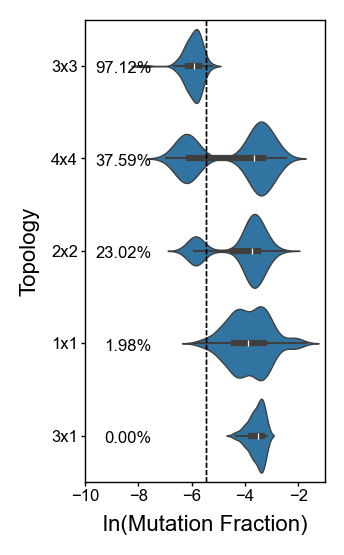

In [46]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cc,
    "ln_r_data",
    "m_token",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Topology")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [47]:
df_pdb_cc.query("m_token.isnull()")

,m_sequence,r_nuc,pdb_r_pos,r_type,pdb_r_bp_type,pdb_r_pair,no_of_conformations,no_of_interactions,no_of_partner_interactions,pdb_name,...,p5_type,p3_res,p3_type,r_data,r_loc_pos,r_pos,r_stack,ln_r_data,z_score,r_data_outlier


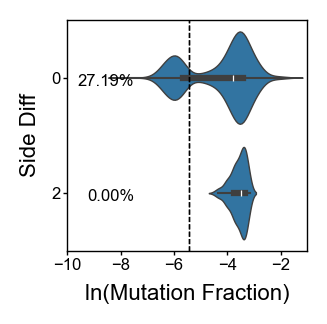

In [48]:
df_pdb_cc = df_pdb_cc.query("not m_token.isnull()")
df_pdb_cc = df_pdb_cc.query("m_token != '6x3'")
df_pdb_cc.query("m_token.isnull()")
df_pdb_cc = add_side_diff_column(df_pdb_cc)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_cc,
    "ln_r_data",
    "side_diff",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Side Diff")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)